In [ ]:
import pandas as pd

df = pd.read_csv("merged_dataset.csv")
df

,text,label,label_enc
0,when i remember her i feel down,emotional pain,6
1,when i carry heavy things i feel like breaking...,hair falling out,10
2,there is too much pain when i move my arm,heart hurts,13
3,my son had his lip pierced and it is swollen a...,infected wound,14
4,my muscles in my lower back are aching,infected wound,14
...,...,...,...
83831,How long have you been experiencing aching wrist?,wrist pain,104
83832,Can you help me with wrist pain that I've been...,wrist pain,104
83833,Can you describe the wrist pain?,wrist pain,104
83834,Could you examine my carpal pain that I've bee...,wrist pain,104


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import gc


In [ ]:
if 'label_enc' in df.columns:
    df = df.drop('label_enc', axis=1)
    print("  Dropped old label_enc column")

# Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

NUM_CLASSES = len(le.classes_)
print(f"\n✓ Label encoding complete:")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Range: 0 to {df['label_enc'].max()}")

# Validate
assert df['label_enc'].min() == 0
assert df['label_enc'].max() == NUM_CLASSES - 1
assert df['label_enc'].nunique() == NUM_CLASSES

  Dropped old label_enc column

✓ Label encoding complete:
  Classes: 105
  Range: 0 to 104


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(),
    df["label_enc"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label_enc"]
)

print(f"✓ Training samples: {len(train_texts):,}")
print(f"✓ Validation samples: {len(val_texts):,}")
print(f"✓ Classes represented: {len(set(train_labels))}/{NUM_CLASSES}")

✓ Training samples: 67,068
✓ Validation samples: 16,768
✓ Classes represented: 105/105


In [ ]:
USE_BIOBERT = True  # Set to False for faster training with DistilBERT

if USE_BIOBERT:
    MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"
    print("✓ Using BioBERT (optimized for medical text)")
else:
    MODEL_NAME = "distilbert-base-uncased"
    print("✓ Using DistilBERT (faster, lighter)")

print(f"  Model: {MODEL_NAME}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✓ Tokenizer loaded")

# Tokenize
print("\nTokenizing texts...")
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,  # Good balance of context vs speed
    return_tensors=None
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors=None
)
print("✓ Tokenization complete")

✓ Using BioBERT (optimized for medical text)
  Model: dmis-lab/biobert-base-cased-v1.1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✓ Tokenizer loaded

Tokenizing texts...
✓ Tokenization complete


In [ ]:
print("\n" + "="*70)
print("STEP 4: Creating Datasets")
print("="*70)

class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = MedicalDataset(train_encodings, train_labels)
val_dataset = MedicalDataset(val_encodings, val_labels)

print(f"✓ Train dataset: {len(train_dataset):,} samples")
print(f"✓ Val dataset: {len(val_dataset):,} samples")


STEP 4: Creating Datasets
✓ Train dataset: 67,068 samples
✓ Val dataset: 16,768 samples


In [ ]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

print(f"✓ Model loaded")
print(f"  Config num_labels: {model.config.num_labels}")

# Verify configuration
if model.config.num_labels != NUM_CLASSES:
    raise ValueError(
        f"Model config mismatch! "
        f"Expected {NUM_CLASSES}, got {model.config.num_labels}"
    )


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded
  Config num_labels: 105


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    # Move model
    model = model.to(device)

    print("\nTesting model with dummy input...")
    with torch.no_grad():
        dummy_input_ids = torch.randint(0, 1000, (2, 10)).to(device)
        dummy_attention = torch.ones(2, 10).to(device)
        dummy_labels = torch.randint(0, NUM_CLASSES, (2,)).to(device)

        outputs = model(
            input_ids=dummy_input_ids,
            attention_mask=dummy_attention,
            labels=dummy_labels
        )

    print(f"✓ Test forward pass successful")
    print(f"  Output shape: {outputs.logits.shape}")
    print(f"  Expected: (batch_size, {NUM_CLASSES})")

    if outputs.logits.shape[1] != NUM_CLASSES:
        raise ValueError(f"Output dimension mismatch!")

except RuntimeError as e:
    if "CUDA" in str(e):
        print(f"\n❌ CUDA Error during model.to(device): {e}")
        print("\n🔧 This means the CUDA error is still present!")
        print("   You MUST restart your runtime:")
        print("   1. Runtime → Restart runtime")
        print("   2. Re-load your data")
        print("   3. Run this script again")
        raise
    else:
        raise



Testing model with dummy input...
✓ Test forward pass successful
  Output shape: torch.Size([2, 105])
  Expected: (batch_size, 105)


In [ ]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sarim-ahsan101 (sarim-ahsan101-sir-syed-university-of-engineering-and-te) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
print("\n" + "="*70)
print("STEP 7: Training Configuration")
print("="*70)

training_args = TrainingArguments(
    output_dir="./medical_classifier_results",
    num_train_epochs=3,  # Start with 3, increase if needed
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,  # Larger for eval (no gradients)
    learning_rate=2e-5,  # Standard for BERT fine-tuning
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,  # Keep only best 2 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),  # Use mixed precision on GPU
    dataloader_num_workers=2,  # Parallel data loading
    report_to="wandb",  # Disable wandb/tensorboard
    push_to_hub=False,
)

print("✓ Training arguments configured")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  FP16: {training_args.fp16}")


STEP 7: Training Configuration
✓ Training arguments configured
  Epochs: 3
  Batch size: 16
  Learning rate: 2e-05
  FP16: True


In [ ]:
def compute_metrics(eval_pred):
    """Compute accuracy and F1 score"""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    # Sanity check
    if preds.min() < 0 or preds.max() >= NUM_CLASSES:
        print(f"⚠️ Predictions out of range: {preds.min()} to {preds.max()}")

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("✓ Trainer created successfully")


✓ Trainer created successfully


/tmp/ipython-input-735314408.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
try:
    eval_results = trainer.evaluate()

    print("\n✅ SUCCESS! Model evaluation working correctly!")
    print("\n📊 Initial Results (before training):")
    print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"  F1 Score: {eval_results['eval_f1']:.4f}")
    print(f"  Loss: {eval_results['eval_loss']:.4f}")

except Exception as e:
    print(f"\n❌ Evaluation failed: {e}")
    print("\n🔍 Debug info:")

    dataloader = trainer.get_eval_dataloader()
    sample = next(iter(dataloader))

    print(f"  Batch keys: {sample.keys()}")
    for key, val in sample.items():
        if torch.is_tensor(val):
            print(f"  {key}: shape={val.shape}, dtype={val.dtype}, device={val.device}")
            if key == 'labels':
                print(f"    min={val.min()}, max={val.max()}")

    print(f"\n  Model device: {next(model.parameters()).device}")
    print(f"  Model num_labels: {model.config.num_labels}")
    raise



✅ SUCCESS! Model evaluation working correctly!

📊 Initial Results (before training):
  Accuracy: 0.0085
  F1 Score: 0.0004
  Loss: 4.6958


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,0.034500,0.031397,0.005300,0.987894,0.987555
2,0.017100,0.019440,0.005300,0.989027,0.988439
3,0.016500,0.019334,0.005300,0.988967,0.988386


TrainOutput(global_step=12576, training_loss=0.2952324712208209, metrics={'train_runtime': 1080.5805, 'train_samples_per_second': 186.2, 'train_steps_per_second': 11.638, 'total_flos': 4553652342029472.0, 'train_loss': 0.2952324712208209, 'epoch': 3.0})

In [ ]:
import os
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification
save_path = "/content/medical_symptom_classifier"

os.makedirs(save_path, exist_ok=True)

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

with open(f"{save_path}/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print(f"✅ Model saved to: {save_path}")


✅ Model saved to: /content/medical_symptom_classifier


In [ ]:
def predict_text(text, model, tokenizer, label_encoder, device):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=1).item()

    # Decode label
    pred_label = label_encoder.inverse_transform([pred_id])[0]

    return pred_label


In [ ]:
text = "The patient feel sleeplessness, loss of interest, "
prediction = predict_text(text, model, tokenizer, le, device)

print("Predicted class:", prediction)


Predicted class: insomnia


In [ ]:
import numpy as np

predictions = trainer.predict(val_dataset)

logits = predictions.predictions
true_labels = predictions.label_ids
pred_labels = np.argmax(logits, axis=1)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    true_labels,
    pred_labels,
    target_names=le.classes_
))


                       precision    recall  f1-score   support

                 acne       1.00      1.00      1.00       213
    allergic reaction       1.00      1.00      1.00       147
       anxiety attack       1.00      0.90      0.95       147
             arm pain       1.00      1.00      1.00       147
      asthma symptoms       1.00      1.00      1.00       147
          back injury       1.00      1.00      1.00       147
            back pain       1.00      1.00      1.00       199
    bladder infection       1.00      1.00      1.00       147
             bleeding       1.00      1.00      1.00       147
       blood in urine       1.00      1.00      1.00       147
blood pressure issues       1.00      1.00      1.00       147
        blurry vision       1.00      1.00      1.00       196
      body feels weak       1.00      1.00      1.00       195
        bone fracture       1.00      1.00      1.00       147
   breathing problems       1.00      1.00      1.00  

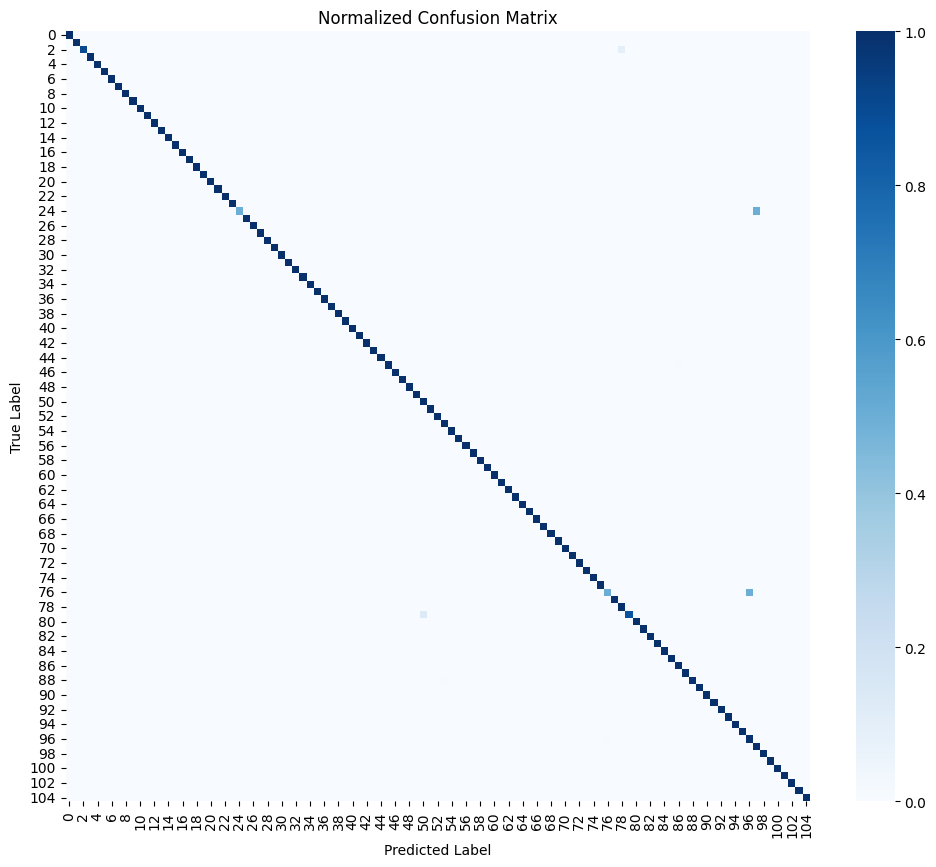

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, normalize="true")

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


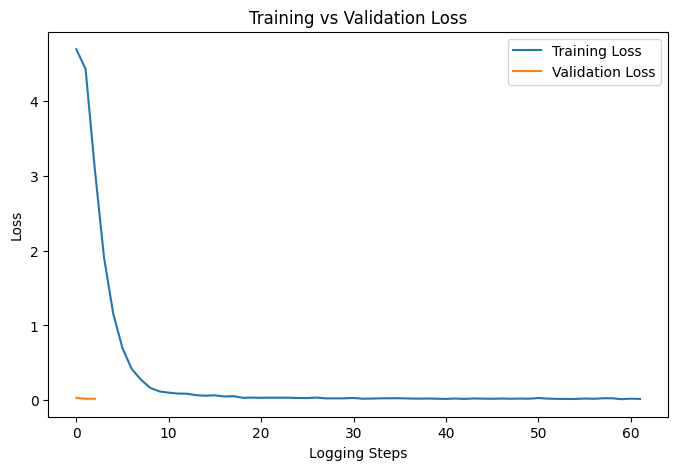

In [ ]:
logs = trainer.state.log_history

train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


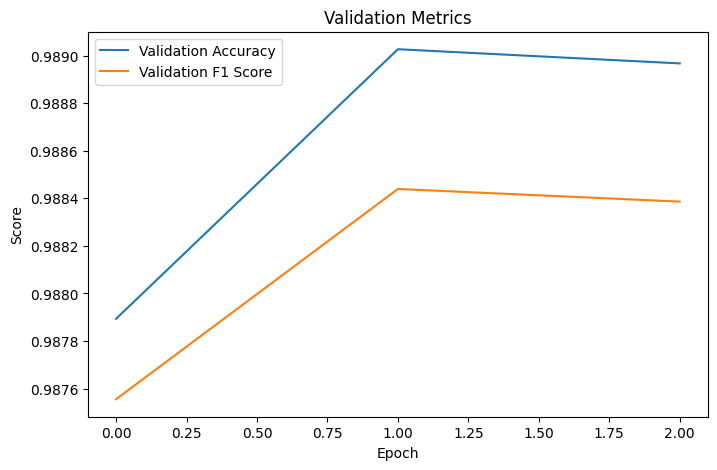

In [ ]:
eval_acc = [x["eval_accuracy"] for x in logs if "eval_accuracy" in x]
eval_f1 = [x["eval_f1"] for x in logs if "eval_f1" in x]

plt.figure(figsize=(8, 5))
plt.plot(eval_acc, label="Validation Accuracy")
plt.plot(eval_f1, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

p, r, f1, s = precision_recall_fscore_support(
    true_labels,
    pred_labels,
    average=None
)

class_metrics = pd.DataFrame({
    "class": le.classes_,
    "precision": p,
    "recall": r,
    "f1": f1,
    "support": s
})

class_metrics.sort_values("f1").head(10)  # worst classes


,class,precision,recall,f1,support
24,dental pain,1.000000,0.496599,0.663636,147
76,numbness,0.986667,0.503401,0.666667,147
96,tingling sensation,0.666667,0.993197,0.797814,147
97,toothache,0.665158,1.000000,0.798913,147
79,rash,1.000000,0.863946,0.927007,147
50,hives,0.880240,1.000000,0.936306,147
2,anxiety attack,1.000000,0.904762,0.950000,147
78,panic attack,0.913043,1.000000,0.954545,147
88,skin issue,1.000000,0.994975,0.997481,199
45,heart hurts,1.000000,0.995050,0.997519,202


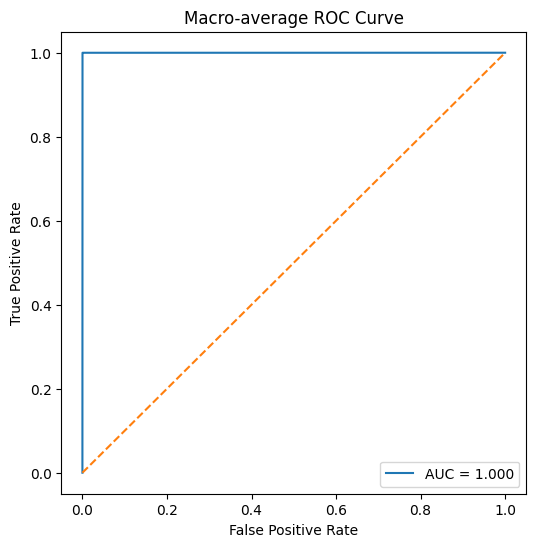

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(true_labels, classes=range(NUM_CLASSES))
y_score = torch.softmax(torch.tensor(logits), dim=1).numpy()

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-average ROC Curve")
plt.legend()
plt.show()
